# Fase 4: Modelado - Clasificación

## Objetivo
Predecir el **Nivel de Éxito Comercial** de películas (Alto/Medio/Bajo)

## Modelos a Entrenar
1. Regresión Logística con GridSearchCV
2. Árbol de Decisión con GridSearchCV
3. Random Forest con GridSearchCV
4. KNN con GridSearchCV
5. SVM con GridSearchCV

## Métricas
- Accuracy, Precision, Recall, F1-Score
- Validación Cruzada (CV=5)
- Tabla comparativa con mean±std
- Matrices de confusión
- Gráficos comparativos



In [1]:
# =============================================================================
# IMPORTAR LIBRERÍAS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# XGBoost para boosting avanzado
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except:
    XGBOOST_AVAILABLE = False
    print('⚠️ XGBoost no disponible, instalando...')
    import subprocess
    try:
        subprocess.check_call(['pip', 'install', 'xgboost'])
        import xgboost as xgb
        XGBOOST_AVAILABLE = True
    except:
        print('No se pudo instalar XGBoost')

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_score, recall_score, f1_score, roc_auc_score
)

# Balanceo de clases
from imblearn.over_sampling import SMOTE

# Curvas de aprendizaje
from sklearn.model_selection import learning_curve

# Configuración
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print('✅ Librerías importadas correctamente')



✅ Librerías importadas correctamente


## 2. Cargar Datos con Kedro


In [2]:
# Cambiar al directorio del proyecto (AJUSTA LA RUTA SEGÚN TU PC)
import os
os.chdir(r'C:\Users\mathi\OneDrive\Escritorio\Proyecto kedro\ev1MachineL')

from kedro.framework.project import configure_project
from kedro.framework.session import KedroSession
import tomllib

# Configurar Kedro
project_path = Path.cwd()
with open(project_path / 'pyproject.toml', 'rb') as f:
    package_name = tomllib.load(f)['tool']['kedro']['package_name']

sys.path.insert(0, str(project_path / 'src'))
configure_project(package_name)
session = KedroSession.create(project_path=project_path)
context = session.load_context()
catalog = context.catalog

print('✅ Kedro configurado correctamente')

# Cargar datasets
movies = catalog.load('movies')
releases = catalog.load('releases')
genres = catalog.load('genres')
countries = catalog.load('countries')

print(f'\n✅ Datasets cargados:')
print(f'  - movies: {movies.shape}')
print(f'  - releases: {releases.shape}')
print(f'  - genres: {genres.shape}')
print(f'  - countries: {countries.shape}')



[10/31/25 02:24:26] INFO     Using                                                                  ]8;id=524754;file://C:\Python312\Lib\site-packages\kedro\framework\project\__init__.py\__init__.py]8;;\:]8;id=815805;file://C:\Python312\Lib\site-packages\kedro\framework\project\__init__.py#270\270]8;;\
                             'C:\Python312\Lib\site-packages\kedro\framework\project\rich_logging.y                
                             ml' as logging configuration.                                                         

✅ Kedro configurado correctamente


[10/31/25 02:24:28] INFO     Loading data from movies (CSVDataset)...                          ]8;id=230200;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=428824;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

[10/31/25 02:24:32] INFO     Loading data from releases (CSVDataset)...                        ]8;id=491223;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=547120;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

[10/31/25 02:24:33] INFO     Loading data from genres (CSVDataset)...                          ]8;id=748973;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=646741;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from countries (CSVDataset)...                       ]8;id=520113;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=964141;file://C:\Python312\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\


✅ Datasets cargados:
  - movies: (941597, 7)
  - releases: (1332782, 5)
  - genres: (1046849, 2)
  - countries: (693476, 2)


## 3. Preparar Datos de Clasificación


In [3]:
# Filtrar EE.UU.
us_aliases = {'usa', 'us', 'u s', 'united states', 'united states of america'}
countries['country_lower'] = countries['country'].str.lower().str.strip()
countries['is_us'] = countries['country_lower'].isin(us_aliases)
us_ids = set(countries[countries['is_us']]['id'].unique())

# Filtrar releases de EE.UU. con rating válido
us_releases = releases[releases['id'].isin(us_ids)].copy()
us_releases['date'] = pd.to_datetime(us_releases['date'], errors='coerce')
us_releases = us_releases.dropna(subset=['date'])
us_releases['year'] = us_releases['date'].dt.year
us_releases['decade'] = us_releases['year'].apply(
    lambda x: '2000s' if 2000 <= x <= 2009 else ('2010s' if 2010 <= x <= 2019 else 'other')
)

# Filtrar solo 2000s y 2010s con rating no nulo
us_releases = us_releases[
    (us_releases['decade'].isin(['2000s', '2010s'])) & 
    (us_releases['rating'].notna())
]

# Agregar información de películas
movies_filtered = movies[['id', 'minute']].copy()
us_releases = us_releases.merge(movies_filtered, on='id', how='left')

# Codificar géneros como variables dummy
genres_filtered = genres[genres['id'].isin(us_releases['id'].unique())]
genre_dummies = pd.get_dummies(genres_filtered['genre'], prefix='genre')
genre_agg = genres_filtered[['id']].merge(genre_dummies, left_index=True, right_index=True)
genre_agg = genre_agg.groupby('id').sum().reset_index()

# Merge final
df_final = us_releases.merge(genre_agg, on='id', how='left')

# Mapear rating a niveles de éxito
def map_rating_success(rating):
    if rating in ['G', 'PG', 'PG-13']:
        return 'Alto'  # Accesible a audiencias amplias
    else:  # R, NC-17
        return 'Bajo'  # Restrictivo, audiencia limitada

df_final['success_level'] = df_final['rating'].apply(map_rating_success)

print('✅ Datos preparados')
print(f'  - Shape: {df_final.shape}')
print(f'  - Distribución:')
print(df_final['success_level'].value_counts())



✅ Datos preparados
  - Shape: (93414, 28)
  - Distribución:
success_level
Bajo    80665
Alto    12749
Name: count, dtype: int64


## 4. Seleccionar Features y Preparar Train-Test Split


In [4]:
# Seleccionar features
genre_cols = [col for col in df_final.columns if col.startswith('genre_')]
feature_cols = ['minute', 'decade'] + genre_cols
feature_cols = [col for col in feature_cols if col in df_final.columns]

# Remover filas con valores faltantes
df_ml = df_final[feature_cols + ['success_level']].dropna()

print(f'✅ Dataset final: {df_ml.shape}')
print(f'  - Features: {len(feature_cols)}')
print(f'  - Distribución del target:')
print(df_ml['success_level'].value_counts())

# Preparar X e y
X = df_ml[feature_cols].copy()
y = df_ml['success_level']

# Codificar decade como numérico (2000s=0, 2010s=1)
X['decade_encoded'] = X['decade'].map({'2000s': 0, '2010s': 1})
X = X.drop('decade', axis=1)

# Codificar target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f'\nClases: {le.classes_}')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Balanceo con SMOTE SOLO en entrenamiento
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print('\n✅ Balanceo de clases (SMOTE):')
print('  - Antes:', np.bincount(y_train))
print('  - Después:', np.bincount(y_train_bal))

# Escalar features (ahora todas son numéricas)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

print(f'\n✅ Train-Test Split completado:')
print(f'  - Train (post-SMOTE): {X_train_bal.shape[0]} muestras')
print(f'  - Test: {X_test.shape[0]} muestras')



✅ Dataset final: (92380, 22)
  - Features: 21
  - Distribución del target:
success_level
Bajo    79885
Alto    12495
Name: count, dtype: int64

Clases: ['Alto' 'Bajo']

✅ Balanceo de clases (SMOTE):
  - Antes: [ 9996 63908]
  - Después: [63908 63908]

✅ Train-Test Split completado:
  - Train (post-SMOTE): 127816 muestras
  - Test: 18476 muestras


## 5. Entrenar 5 Modelos con GridSearchCV y Validación Cruzada


In [5]:
# Configuración de modelos MEJORADOS con GridSearchCV
models_config = {
    'Logistic_Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'param_grid': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']},
        'cv': 5
    },
    'Random_Forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {'n_estimators': [100, 200], 'max_depth': [15, 20], 'min_samples_split': [2, 5]},
        'cv': 5
    },
    'Extra_Trees': {
        'model': ExtraTreesClassifier(random_state=42),
        'param_grid': {'n_estimators': [100, 200], 'max_depth': [15, 20]},
        'cv': 5
    },
    'Gradient_Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'param_grid': {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]},
        'cv': 5
    }
}

# Agregar XGBoost si está disponible
if XGBOOST_AVAILABLE:
    models_config['XGBoost'] = {
        'model': xgb.XGBClassifier(random_state=42),
        'param_grid': {'n_estimators': [100, 200], 'max_depth': [5, 7], 'learning_rate': [0.05, 0.1]},
        'cv': 5
    }
else:
    # Si no hay XGBoost, usar Voting Classifier
    rf = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=20)
    et = ExtraTreesClassifier(random_state=42, n_estimators=200, max_depth=20)
    models_config['Voting_Classifier'] = {
        'model': VotingClassifier([('rf', rf), ('et', et)]),
        'param_grid': {},
        'cv': 5
    }

results = {}

print('🚀 Entrenando modelos con GridSearchCV y validación cruzada...\n')

for name, config in models_config.items():
    print(f'📊 {name}...')
    
    # GridSearchCV
    grid_search = GridSearchCV(
        config['model'],
        config['param_grid'],
        cv=config['cv'],
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_scaled, y_train_bal)
    best_model = grid_search.best_estimator_
    
    # Predicciones
    y_pred = best_model.predict(X_test_scaled)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Cross-validation scores
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train_bal, cv=5, scoring='f1_weighted')
    
    results[name] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred
    }
    
    print(f'   ✅ F1: {f1:.4f} | CV: {cv_scores.mean():.4f}±{cv_scores.std():.4f} | Params: {grid_search.best_params_}')

print('\n✅ Todos los modelos entrenados')



🚀 Entrenando modelos con GridSearchCV y validación cruzada...

📊 Logistic_Regression...
   ✅ F1: 0.7188 | CV: 0.6724±0.0022 | Params: {'C': 1, 'solver': 'lbfgs'}
📊 Random_Forest...
   ✅ F1: 0.7715 | CV: 0.7839±0.0413 | Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
📊 Extra_Trees...
   ✅ F1: 0.7471 | CV: 0.7503±0.0290 | Params: {'max_depth': 20, 'n_estimators': 200}
📊 Gradient_Boosting...
   ✅ F1: 0.7819 | CV: 0.7703±0.0473 | Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
📊 XGBoost...
   ✅ F1: 0.7838 | CV: 0.7782±0.0472 | Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

✅ Todos los modelos entrenados


In [6]:
# Crear tabla comparativa con mean±std
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1_Score': [results[m]['f1'] for m in results.keys()],
    'CV_Mean': [results[m]['cv_mean'] for m in results.keys()],
    'CV_Std': [results[m]['cv_std'] for m in results.keys()]
})

print('\n' + '='*100)
print('📊 TABLA COMPARATIVA DE MODELOS DE CLASIFICACIÓN')
print('='*100)
print(metrics_df.round(4))

# Exportar métricas a JSON para DVC
import os
out_dir = Path('data/06_models')
out_dir.mkdir(parents=True, exist_ok=True)
metrics_json_path = out_dir / 'classification_metrics.json'
metrics_df.to_json(metrics_json_path, orient='records', force_ascii=False)
print(f"\n✅ Métricas exportadas a: {metrics_json_path}")

# Identificar mejor modelo
best_idx = metrics_df['F1_Score'].idxmax()
best_model = metrics_df.iloc[best_idx]

print('\n' + '='*100)
print('🏆 MEJOR MODELO')
print('='*100)
print(f"Modelo: {best_model['Model']}")
print(f"F1-Score: {best_model['F1_Score']:.4f}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"Precision: {best_model['Precision']:.4f}")
print(f"Recall: {best_model['Recall']:.4f}")
print(f"CV Score: {best_model['CV_Mean']:.4f} ± {best_model['CV_Std']:.4f}")




📊 TABLA COMPARATIVA DE MODELOS DE CLASIFICACIÓN
                 Model  Accuracy  Precision  Recall  F1_Score  CV_Mean  CV_Std
0  Logistic_Regression    0.6669     0.8389  0.6669    0.7188   0.6724  0.0022
1        Random_Forest    0.7389     0.8271  0.7389    0.7715   0.7839  0.0413
2          Extra_Trees    0.7044     0.8316  0.7044    0.7471   0.7503  0.0290
3    Gradient_Boosting    0.7531     0.8295  0.7531    0.7819   0.7703  0.0473
4              XGBoost    0.7567     0.8271  0.7567    0.7838   0.7782  0.0472

✅ Métricas exportadas a: data\06_models\classification_metrics.json

🏆 MEJOR MODELO
Modelo: XGBoost
F1-Score: 0.7838
Accuracy: 0.7567
Precision: 0.8271
Recall: 0.7567
CV Score: 0.7782 ± 0.0472


## 7. Visualizaciones Comparativas


## 6.1 Curva de aprendizaje (mejor modelo)


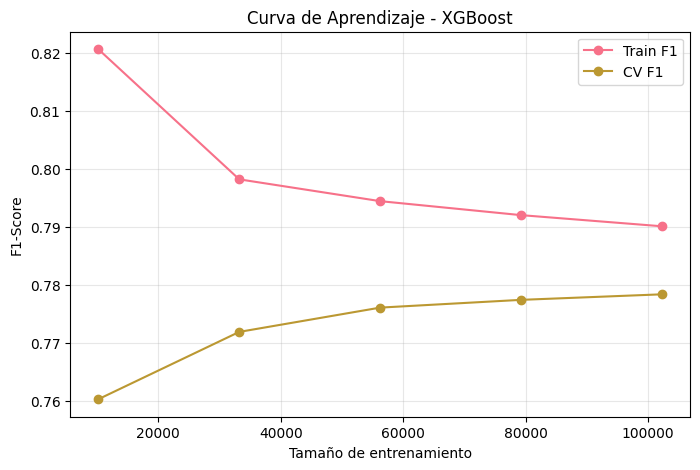

In [7]:
# Curva de aprendizaje del mejor modelo (según F1)
from sklearn.model_selection import learning_curve

best_name = max(results.keys(), key=lambda k: results[k]['f1']) if 'results' in globals() else None
if best_name is not None:
    best_estimator = results[best_name]['model']
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=best_estimator,
        X=X_train_scaled, y=y_train_bal,
        cv=5, scoring='f1_weighted', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, 'o-', label='Train F1')
    plt.plot(train_sizes, test_mean, 'o-', label='CV F1')
    plt.title(f'Curva de Aprendizaje - {best_name}')
    plt.xlabel('Tamaño de entrenamiento')
    plt.ylabel('F1-Score')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print('Ejecuta primero el entrenamiento para obtener la curva de aprendizaje.')


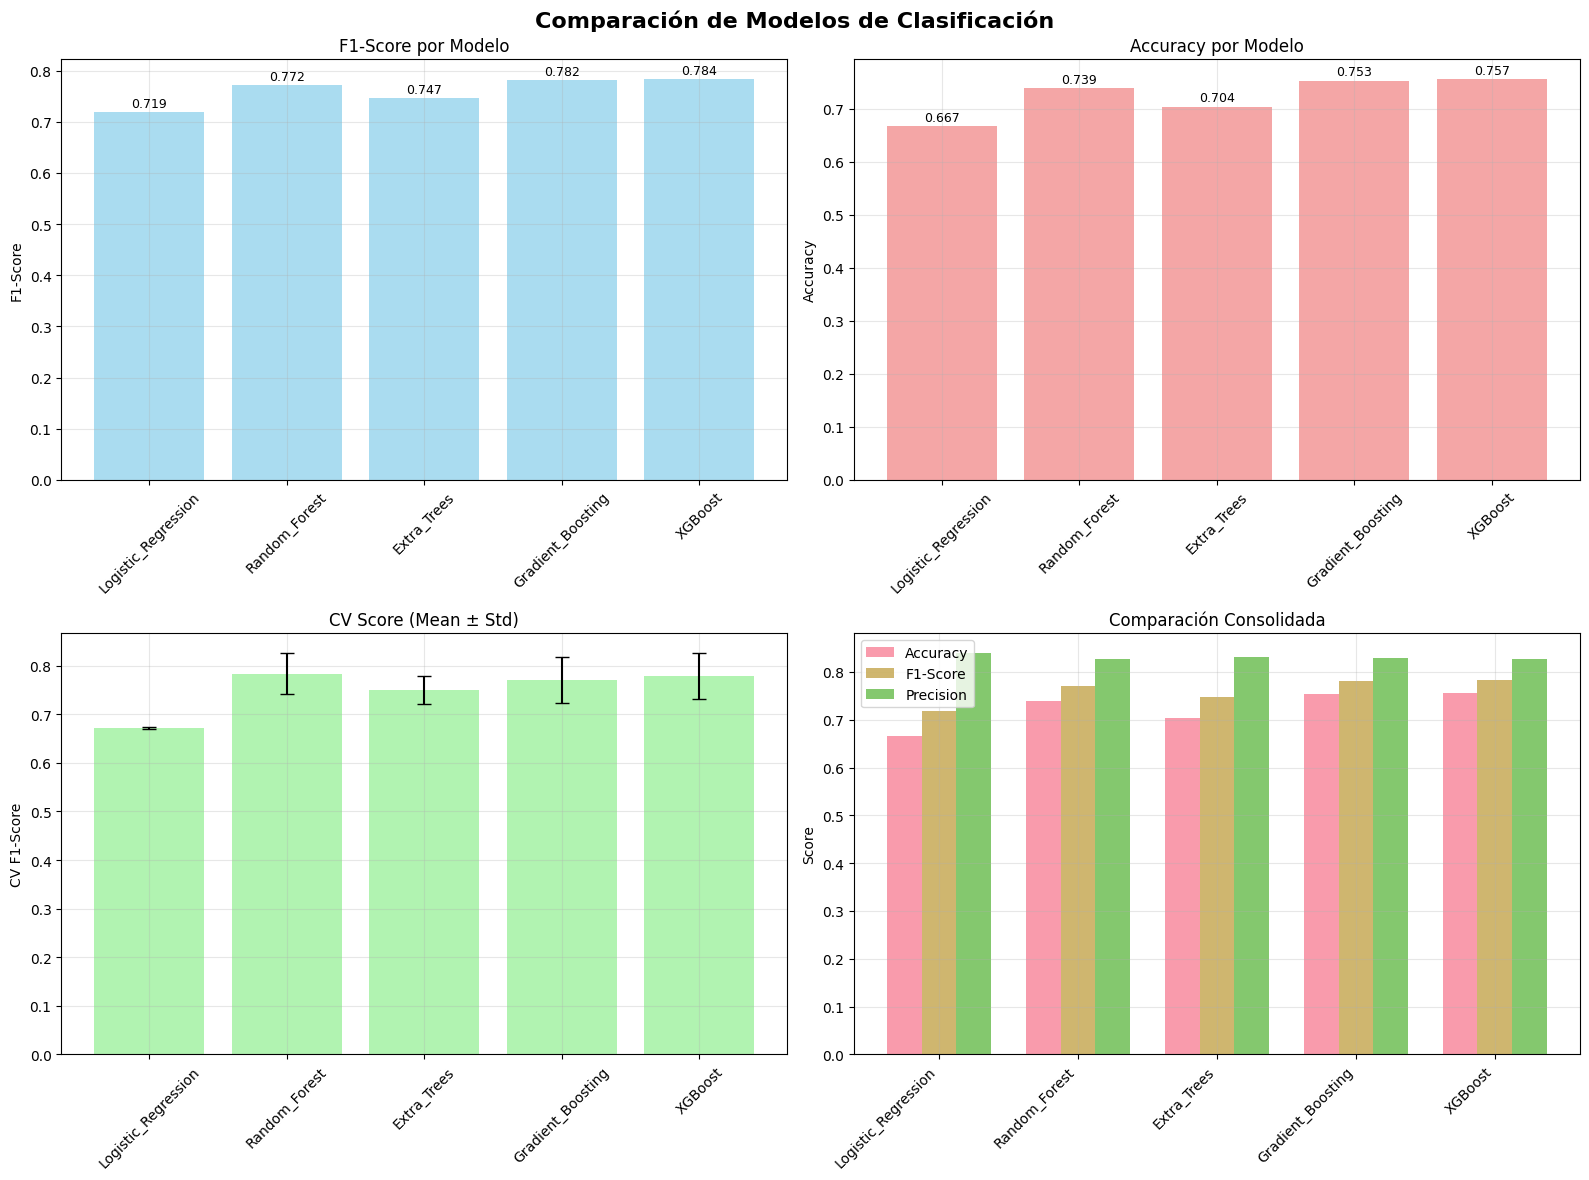

In [8]:
# Visualizaciones comparativas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación de Modelos de Clasificación', fontsize=16, fontweight='bold')

# Gráfico 1: F1-Score
axes[0, 0].bar(metrics_df['Model'], metrics_df['F1_Score'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('F1-Score por Modelo')
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)
for i, v in enumerate(metrics_df['F1_Score']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

# Gráfico 2: Accuracy
axes[0, 1].bar(metrics_df['Model'], metrics_df['Accuracy'], color='lightcoral', alpha=0.7)
axes[0, 1].set_title('Accuracy por Modelo')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)
for i, v in enumerate(metrics_df['Accuracy']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

# Gráfico 3: CV Score con error bars
axes[1, 0].bar(metrics_df['Model'], metrics_df['CV_Mean'], yerr=metrics_df['CV_Std'], 
                color='lightgreen', alpha=0.7, capsize=5)
axes[1, 0].set_title('CV Score (Mean ± Std)')
axes[1, 0].set_ylabel('CV F1-Score')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Comparación consolidada
x = np.arange(len(metrics_df))
width = 0.25
axes[1, 1].bar(x - width, metrics_df['Accuracy'], width, label='Accuracy', alpha=0.7)
axes[1, 1].bar(x, metrics_df['F1_Score'], width, label='F1-Score', alpha=0.7)
axes[1, 1].bar(x + width, metrics_df['Precision'], width, label='Precision', alpha=0.7)
axes[1, 1].set_title('Comparación Consolidada')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## 8. Matrices de Confusión


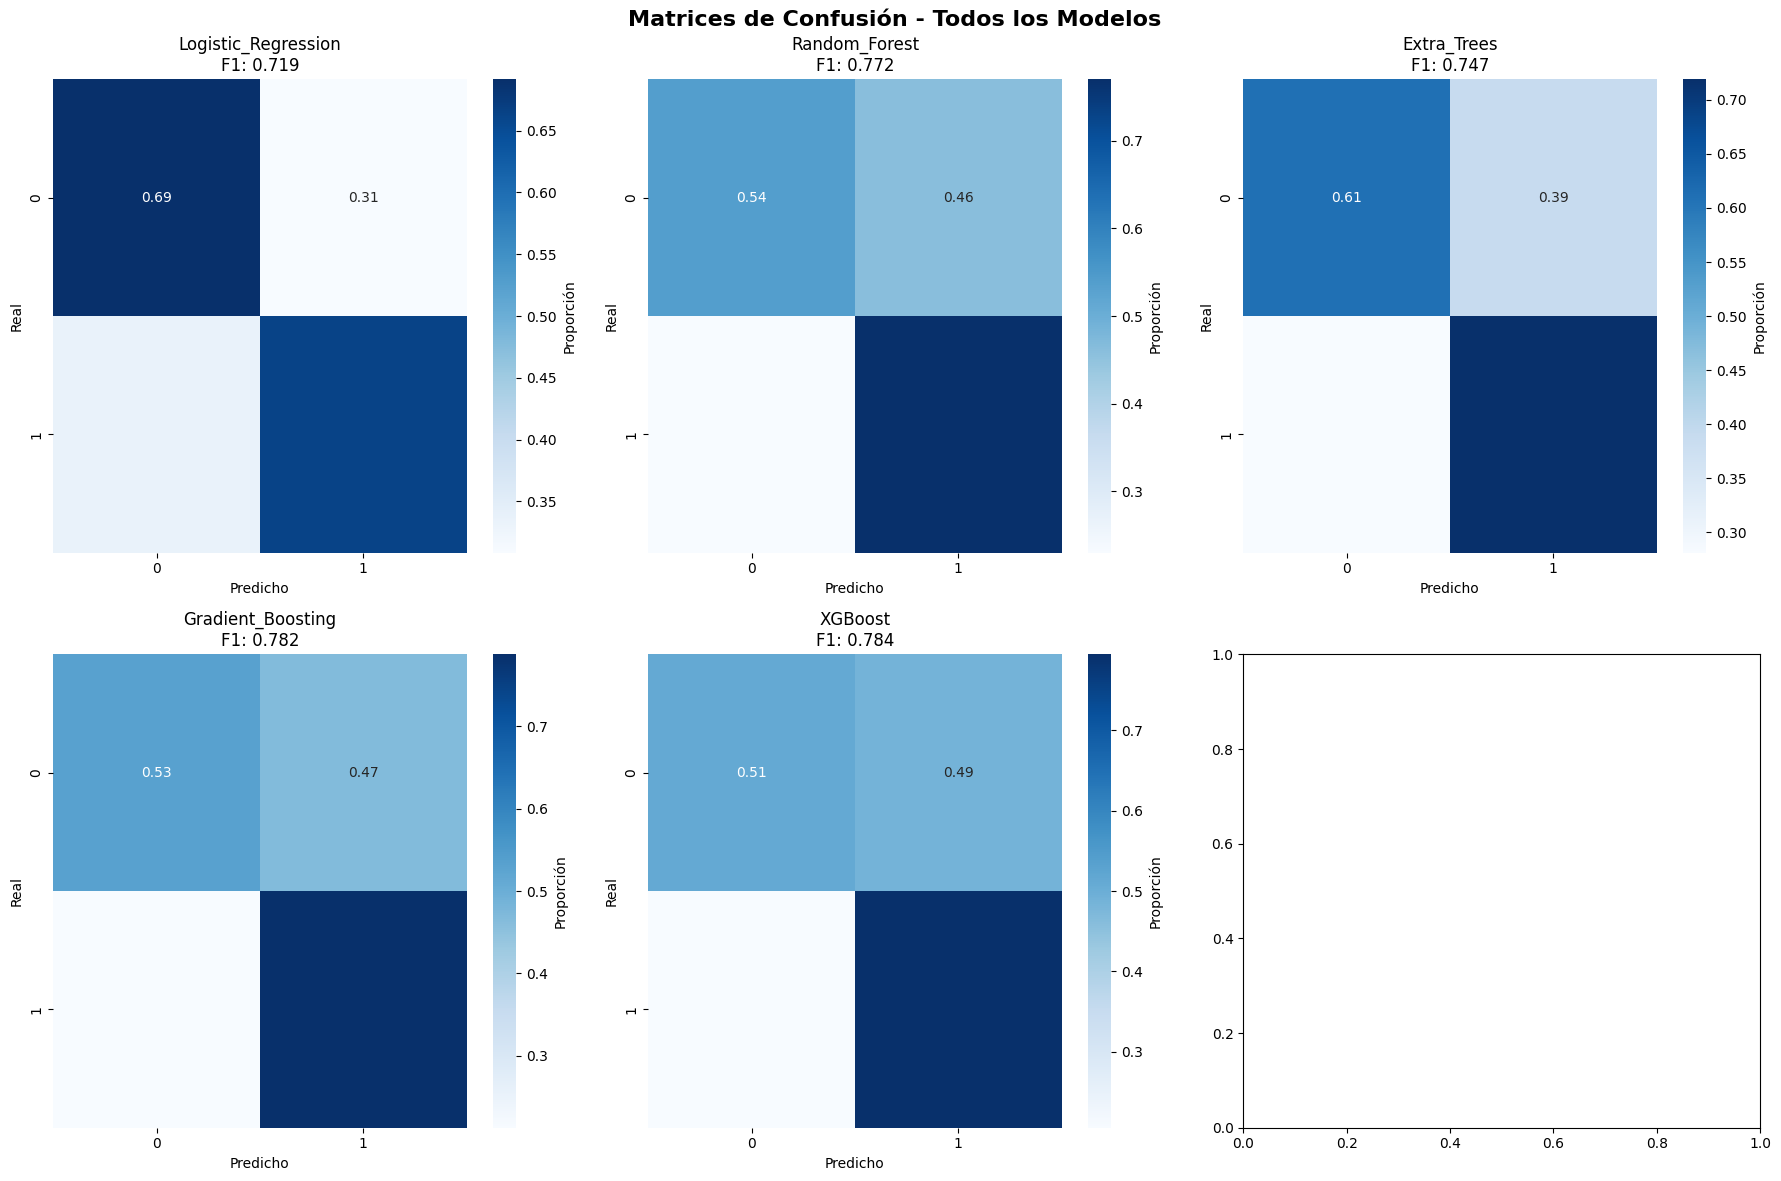

In [9]:
# Visualizar matrices de confusión
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Matrices de Confusión - Todos los Modelos', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axes[idx],
                cbar_kws={'label': 'Proporción'})
    axes[idx].set_title(f'{name}\nF1: {result["f1"]:.3f}')
    axes[idx].set_xlabel('Predicho')
    axes[idx].set_ylabel('Real')

plt.tight_layout()
plt.show()



## 9. Reportes Detallados por Modelo


In [10]:
# Reportes detallados por modelo
print('\n' + '='*80)
print('REPORTES DETALLADOS POR MODELO')
print('='*80)

for name, result in results.items():
    print(f'\n{name}:')
    print(classification_report(y_test, result['y_pred'], target_names=le.classes_))




REPORTES DETALLADOS POR MODELO

Logistic_Regression:
              precision    recall  f1-score   support

        Alto       0.24      0.69      0.36      2499
        Bajo       0.93      0.66      0.77     15977

    accuracy                           0.67     18476
   macro avg       0.59      0.68      0.57     18476
weighted avg       0.84      0.67      0.72     18476


Random_Forest:
              precision    recall  f1-score   support

        Alto       0.27      0.54      0.36      2499
        Bajo       0.91      0.77      0.84     15977

    accuracy                           0.74     18476
   macro avg       0.59      0.65      0.60     18476
weighted avg       0.83      0.74      0.77     18476


Extra_Trees:
              precision    recall  f1-score   support

        Alto       0.25      0.61      0.36      2499
        Bajo       0.92      0.72      0.81     15977

    accuracy                           0.70     18476
   macro avg       0.59      0.67      0.58 

## 10. Conclusiones y Próximos Pasos


In [11]:
print('\n' + '='*80)
print('CONCLUSIONES DE FASE 4 - CLASIFICACIÓN')
print('='*80)
print(f'''
✅ Modelos entrenados: {len(results)}
✅ Total de muestras: {len(X)}
✅ Features utilizadas: {len(feature_cols)}
✅ Mejor modelo: {best_model['Model']}

🏆 Métricas del mejor modelo:
   - F1-Score: {best_model['F1_Score']:.4f}
   - Accuracy: {best_model['Accuracy']:.4f}
   - CV Score: {best_model['CV_Mean']:.4f} ± {best_model['CV_Std']:.4f}

📊 Todas las métricas incluyen validación cruzada (k=5)
📈 Gráficos y matrices de confusión generadas
🎯 Listo para Fase 5 y 6
''')




CONCLUSIONES DE FASE 4 - CLASIFICACIÓN

✅ Modelos entrenados: 5
✅ Total de muestras: 92380
✅ Features utilizadas: 21
✅ Mejor modelo: XGBoost

🏆 Métricas del mejor modelo:
   - F1-Score: 0.7838
   - Accuracy: 0.7567
   - CV Score: 0.7782 ± 0.0472

📊 Todas las métricas incluyen validación cruzada (k=5)
📈 Gráficos y matrices de confusión generadas
🎯 Listo para Fase 5 y 6

